In [45]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from simulation.rotor import MagneticBearing3D
from simulation.pid import PID
from simulation.seal import Seal
from simulation.excitation_signals import *

In [44]:
env = MagneticBearing3D()
env.reset()
env.dt = 1e-4

pid = PID(kp=7.5e3, kd=18.61, ki=90, dt=env.dt)
force = sweep_fun(1, 4, 60)
#force = sinusoidal(69)

# Seal
K = np.array([[4300, 430],[-430, 430]])
C = np.array([[43, 0],
              [0, 43]])
seal = Seal(K=K, C=C)

In [39]:
num_episodes = 1
T = 2
history = []
pid_history = []
seal_history = []

action = np.array([0, 0, 0, 0])
for _ in range(int(1/env.dt)):
    f = force(_*env.dt)
    obs, done = env.step(action + f)  # take a random action ([0,1.135/2,10,0, 0,1.135/2,0,0.1])
    
    f_ax, f_ay = seal(q=obs[[0,1]], q_dot=obs[[4,5]]).flatten()/2
    f_bx, f_by = seal(q=obs[[2,3]], q_dot=obs[[6,7]]).flatten()/2
    seal_force = np.array([f_ax, f_ay, f_bx, f_by])
    pid_force = pid(obs[:4])
    action = pid_force
    action += seal_force
    action += np.array([env.gravity, 0, env.gravity, 0])/2
    
              
    pid_history.append(pid_force)
    seal_history.append(seal_force)
    history.append(obs)
    
    if done:
        break
    
history = np.array(history)

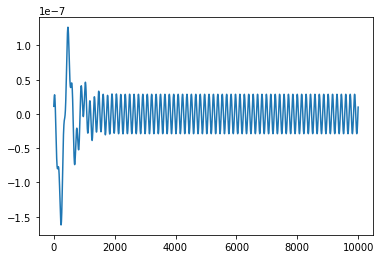

In [37]:
plt.plot(history[:, 1])
#plt.xlim((4000, 8000))
plt.show()

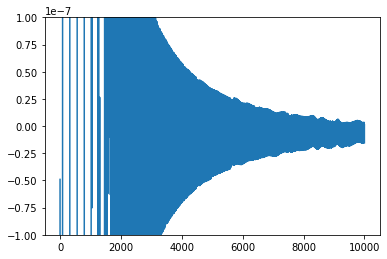

In [41]:
plt.plot(history[:, :1])
plt.ylim((-1e-7, 1e-7))
plt.show()

In [36]:
history.shape

(1000, 8)